# 규칙 기반 기계 번역(RBMT, Rule-Based Machine Translation)

- 번역할 때 경우의 수를 직접 정의해 주는 방식
- 규칙에 없는 문장이 들어올 경우 번역이 불가능하고 유연성이 떨어지짐
- 모든 규칙을 정의하는 과정이 복잡하고 오랜 시간이 필요로 함

# 통계적 기계 번역(SMT, Statistical Machine Translation)
- 데이터로부터 통계적 확률을 구해 번역을 진행한다
- 통계적 언어 모델(SLM, Statistical Language Model)을 기반으로 동작한다 -> 사용되는 언어의 확률 분포를 근사 모델링한다.
- 개발에 대한 비용이 적다
- 많은 데이터가 뒷받침될 경우, 훨씬 더 유연한 문장 생성이 가능하다
- 본 적이 없는 문장에 대한 모델링이 불가능하다(데이터 의존적)
- 문장의 어순에 대한 고려가 없기 때문에 다소 어색한 문장이 생성될 수 있다

- 번역은 자연스러운 문장을 생성하는 것 뿐만 아니라 번역문의 문법 구조도 고려해야 한다. 즉, 원무노가 번역문, 각 단어 가느이 매핑 관계를 추가로 고려해야 함.
- 이러한 관계를 ***정렬(Alignment)*** 라고 한다.

# 정렬
정렬에는 퍼틸리티(Fertility)와 왜곡(Distortion), 두 가지 요소가 포함된다
## 퍼틸리티(Fertility)
- 원문의 각 단어가 번역 후에 몇 개의 단어로 나타나는지를 의미하는 값
- 퍼틸리티에 대한 확률은 p(n|w) 로 정의되며 n은 퍼틸리티 값, w는 원문의 단어
## 왜곡(Distortion)
- 원문의 단어가 번역문에서 존재하는 위치를 나타낸다
- 왜곡에 대한 확률은 p(t|s, l) 로 정의되며 t은 번역문에서 각 단어의 위치, s는 원문에서 각 단어의 위치, 그리고 l은 번역문의 길이

통계적 언어 모델에서 파생된 확률에 위 모든 확률을 곱하여 학습하는 것이 바로 통계적 기계 번역

E: Everyone(1, 2) clapped(6, 7, 8) in(4) time(5) to(·) the(·) music(3)
-> K: 모두(1) 가(2) 음악(3) 에(4) 맞춰(5) 손뼉(6) 을(7) 쳤다(8)

- 이후,  두 단어 이상으로 정렬을 구하는 구문 기반 번역(PBMT, Phrase Based Machine Translation) 이 등장
- 여기서 더 발전하여 신경망 기계 번역이 등장

# 신경망 기계 번역
- 대표적인 모델로 seq2seq나 transformer가 있음

# Greedy Decoding

In [ ]:
# 훈련시킨 모델이 문장을 생성할 수 있게 해주는 함수
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)

    end_token = tokenizer.word_index["<end>"]

    while True:
        predict = model(test_tensor)
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]

        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

- 단어를 결정하는 부분
***predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] ***
-  모델이 예측한 predict 값을 Softmax를 통해 확률값으로 변환한 후, **가장 높은 확률을 갖는 단어가 다음 단어로 결정되는 순간**
- 이는 탐욕적 알고리즘이 사용된 것으로, 탐욕적인 방법으로 문장을 decoding하여, Greedy Decoding이라고 함
- 탐욕적인 방법은 효율적이지만 최적의 해를 구해준다는 보장이 없다.

# Beam Search
- 지금 상황에서 가장 높은 확률을 갖는 Top-k 문장만 사용하여 단어 사전을 만드는 것
- 상위 몇 개의 문장을 기억할지는 Beam Size(혹은 Beam Width라고 함)로 정의할 수 있음
- Beam Size는 연산량과 성능 간의 Trade-off 관계를 가지고 있으므로, 자원을 고려하여 설정


In [ ]:
import math
import numpy as np

def beam_search_decoder(prob, beam_size):
    sequences = [[[], 1.0]]  # 생성된 문장과 점수를 저장

    for tok in prob:
        all_candidates = []

        for seq, score in sequences:
            for idx, p in enumerate(tok): # 각 단어의 확률을 총점에 누적 곱
                candidate = [seq + [idx], score * -math.log(-(p-1))]
                all_candidates.append(candidate)

        ordered = sorted(all_candidates,
                         key=lambda tup:tup[1],
                         reverse=True) # 총점 순 정렬
        sequences = ordered[:beam_size] # Beam Size에 해당하는 문장만 저장 

    return sequences

In [ ]:
vocab = {
    0: "<pad>",
    1: "까요?",
    2: "커피",
    3: "마셔",
    4: "가져",
    5: "될",
    6: "를",
    7: "한",
    8: "잔",
    9: "도",
}

# prob_seq은 문장의 각 위치에서 어떤 단어가 생성될지의 확률을 한 번에 정의해둔 것입니다.
# 실제로는 각 단어에 대한 확률이 prob_seq처럼 한번에 정의되지 않기 때문에 실제 문장 생성과정과는 거리가 멉니다.
# 하지만 Beam Search의 동작과정 이해를 돕기위해 이와 같은 예시를 보여드립니다.
# prob_seq의 각 열은 위 vocab의 각 숫자(key)에 대응됩니다.
prob_seq = [[0.01, 0.01, 0.60, 0.32, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], # 커피 : 0.60
            [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.75, 0.01, 0.01, 0.17], # 를 : 0.75
            [0.01, 0.01, 0.01, 0.35, 0.48, 0.10, 0.01, 0.01, 0.01, 0.01], # 가져 : 0.48
            [0.24, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.68], # 도 : 0.68
            [0.01, 0.01, 0.12, 0.01, 0.01, 0.80, 0.01, 0.01, 0.01, 0.01], # 될 : 0.80
            [0.01, 0.81, 0.01, 0.01, 0.01, 0.01, 0.11, 0.01, 0.01, 0.01], # 까요? : 0.81
            [0.70, 0.22, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], # <pad> : 0.91
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], # <pad> : 0.91
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01], # <pad> : 0.91
            [0.91, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]] # <pad> : 0.91

prob_seq = np.array(prob_seq)
beam_size = 3

result = beam_search_decoder(prob_seq, beam_size)

for seq, score in result:
    sentence = ""

    for word in seq:
        sentence += vocab[word] + " "

    print(sentence, "// Score: %.4f" % score)

In [ ]:
# beam_size 인자 값을 바꿔보세요.
beam_size = 5

result = beam_search_decoder(prob_seq, beam_size)

for seq, score in result:
	sentence = ""
	
	for word in seq:	
		sentence += vocab[word] + " "

	print(sentence, "// Score: %.4f" % score)

Beam Search는 사람이 직접 좋은 번역을 고를 수 있게 상위 K개의 결과를 보여줄 뿐이라서 학습에 직접적으로 적용할 수는 없다.
-> 모델의 학습 단계에서는 Beam Search를 사용하지 않는다.

# Sampling
- 확률적으로 단어를 뽑는 방법
- 간혹 정말 난해한 문장을 생성할 수도 있기 때문에 실제 서비스에서는 거의 사용되지 않음
- 모델을 학습시킬 때는 사용되는 경우가 있는데, Back Translation(역번역)이 이에 해당됨

# Data Augmentation
##  Lexical Substitution(어휘 대체)
### 동의어 기반 대체
- 시소러스(Thesaurus) 란, 어떤 단어의 동의어나 유의어를 집중적으로 구축해놓은 사전을 의미
- 동의어 기반 대체는 이 시소러스를 활용한 방법
- 부산대학교의 KorLex, 카이스트의 Korean WordNet(KWN)이 있음
### Embedding 활용 대체
- 학습된 Embedding은 유사한 단어들끼리 비슷한 공간에 밀집됨
- Embedding의 유사도를 기반으로 단어를 대체
- gensim 라이브러리를 활용, most_similar() 함수
### TF-IDF 기반 대체
- 여러 문서를 기반으로 단어마다 중요도를 부여하는 알고리즘
- 낮은 TF-IDF 값을 갖는 단어들은 핵심 단어가 아니기 때문에 다른 단어로 대체해도 문맥이 크게 변하지 않는다는 것에 주목한 아이디어

##  Back Translation
- 단일 언어 데이터는 구하기 쉽고 많지만 병렬 쌍을 이룬 언어 데이터를 찾기는 어렵다는 문제를 해결하고자 등장
- 번역 모델에 단일 언어 데이터를 학습시키는 방법
- Encoder에는 Source 언어로 된 문장을, Decoder에는 Target 언어로 된 문장을 좀 더 훈련시키면 어떨까


## Random Noise Injection
### 오타 노이즈 추가
- 키보드 상에서의 키의 거리를 기반으로 노이즈를 추가하는 방법
- ㅋㅋㅋㅋㅋ
- ㅋㅋㄷㅋㄷㄷㅋㅋ
### 공백 노이즈 추가
- 엄연히 말하면 완벽한 공백이 아니고, _ 토큰을 활용하며 이를 Placeholder Token(이하 공백 토큰)라고 함
- 문장의 일부 단어를 공백 토큰으로 치환
-  학습의 과적합을 방지하는 데에 좋은 효과를 가지고 있음

- 문장에서 일부 단어를 공백 토큰으로 치환하고, 이를 추측하는 학습 방식을 마스크 언어 모델링(MLM, Masked Language Modeling)이라고 한다
    - BERT(Bidirectional Encoder Representations from Transformers), GPT-2(Generative Pre-trained Transformer 2), XLNet(eXtreme Multi-Lingual Language Model) 

### 랜덤 유의어 추가
- 주어진 문장에서 불용어(Stop word)가 아닌 단어를 랜덤하게 뽑은 후, 해당 단어와 유사한 단어를 골라 문장에 아무렇게나 삽입하는 방식
- 원본 단어가 손실되지 않음
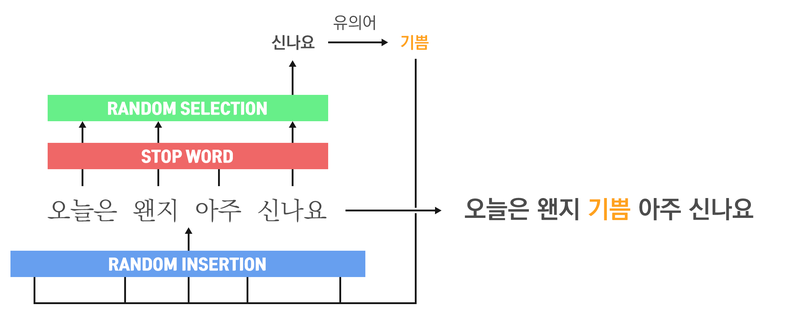

# BLEU(Bilingual Evaluation Understudy) Score
- '기계가 실제 번역을 얼마나 잘 재현했는가?' 를 평가하는 지표
- 같은 단어가 반복되어 높은 점수를 받는 것을 지양
- 단어를 잘 재현하더라도 어순이 엉망인 번역을 지양
- 지나치게 짧은 번역이 높은 점수를 받는 것을 지양
- import nltk.translate.bleu_score as bleu
- [BLEU Score 참고](https://wikidocs.net/31695)

# GLUE
- 자연어 이해를 평가하기 위해 고안된 지표
- [GLUE](https://huffon.github.io/2019/11/16/glue/)

# 좋은 챗봇을 만들려면 고려해야할 점
1. 200ms
- 대화가 자연스럽게 이어지는 공백의 마지노선
- 0.2초 내에 답변이 나오도록 하는 것이 좋다
2. 시공간을 담은 질문
- 시공간에 대한 질문은 다른 모듈로 연결하여 예외 처리
3. 페르소나
- 인격의 일관성
- 제품이나 서비스 목적에 맞게 설정되어야 한다
